In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import logging
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("Optimized libraries imported successfully!")

# Define SMAPE function
def smape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    denominator = (np.abs(actual) + np.abs(predicted))
    denominator = np.where(denominator == 0, 1e-10, denominator)
    
    smape_value = (100 / len(actual)) * np.sum(2 * np.abs(predicted - actual) / denominator)
    return smape_value

# Enhanced feature extraction
def extract_features_enhanced(catalog_text):
    """Enhanced feature extraction with better patterns"""
    features = {
        'weight': 0.0,
        'volume': 0.0, 
        'count': 0.0,
        'catalog_length': 0,
        'num_bullet_points': 0,
        'has_value_field': 0,
        'is_organic': 0,
        'is_gluten_free': 0,
        'is_vegan': 0,
        'is_kosher': 0,
        'is_sugar_free': 0,
        'is_low_carb': 0,
        'is_non_gmo': 0,
        'has_protein_info': 0,
        'has_fiber_info': 0,
        'has_calorie_info': 0,
        'premium_keywords': 0
    }
    
    if pd.isna(catalog_text):
        return features
    
    text = str(catalog_text).lower()
    
    # Basic text features
    features['catalog_length'] = len(text)
    features['num_bullet_points'] = text.count('bullet point')
    
    # Enhanced weight extraction with multiple patterns
    weight_patterns = [
        r'(\d+\.?\d*)\s*oz',
        r'(\d+\.?\d*)\s*ounce',
        r'(\d+\.?\d*)\s*lb',
        r'(\d+\.?\d*)\s*pound',
        r'(\d+\.?\d*)\s*gram',
        r'(\d+\.?\d*)\s*g\b'
    ]
    for pattern in weight_patterns:
        match = re.search(pattern, text)
        if match:
            try:
                weight_val = float(match.group(1))
                # Convert to ounces for consistency
                if 'lb' in pattern or 'pound' in pattern:
                    weight_val *= 16
                elif 'gram' in pattern or r'g\b' in pattern:
                    weight_val *= 0.035274
                features['weight'] = max(features['weight'], weight_val)
            except:
                pass
    
    # Enhanced volume extraction
    volume_patterns = [
        r'(\d+\.?\d*)\s*fl\s*oz',
        r'(\d+\.?\d*)\s*fluid\s*ounce',
        r'(\d+\.?\d*)\s*ml',
        r'(\d+\.?\d*)\s*liter',
        r'(\d+\.?\d*)\s*l\b'
    ]
    for pattern in volume_patterns:
        match = re.search(pattern, text)
        if match:
            try:
                volume_val = float(match.group(1))
                # Convert to fluid ounces
                if 'ml' in pattern:
                    volume_val *= 0.033814
                elif 'liter' in pattern or r'l\b' in pattern:
                    volume_val *= 33.814
                features['volume'] = max(features['volume'], volume_val)
            except:
                pass
    
    # Enhanced count extraction
    count_patterns = [
        r'(\d+)\s*count',
        r'(\d+)\s*pack',
        r'(\d+)\s*ct',
        r'(\d+)\s*tea bags',
        r'(\d+)\s*capsules',
        r'(\d+)\s*pods',
        r'(\d+)\s*cookies',
        r'pack of\s*(\d+)'
    ]
    for pattern in count_patterns:
        match = re.search(pattern, text)
        if match:
            try:
                count_val = float(match.group(1))
                features['count'] = max(features['count'], count_val)
            except:
                pass
    
    # Extract value field if present
    value_match = re.search(r'value:\s*(\d+\.?\d*)', text, re.IGNORECASE)
    if value_match:
        features['has_value_field'] = 1
    
    # Enhanced health and dietary attributes
    features['is_organic'] = 1 if any(term in text for term in ['organic', 'usda organic']) else 0
    features['is_gluten_free'] = 1 if 'gluten free' in text else 0
    features['is_vegan'] = 1 if 'vegan' in text else 0
    features['is_kosher'] = 1 if 'kosher' in text else 0
    features['is_sugar_free'] = 1 if any(term in text for term in ['sugar free', 'no sugar', 'zero sugar']) else 0
    features['is_low_carb'] = 1 if any(term in text for term in ['low carb', 'keto', 'keto-friendly']) else 0
    features['is_non_gmo'] = 1 if any(term in text for term in ['non-gmo', 'non gmo']) else 0
    
    # Nutritional info presence
    features['has_protein_info'] = 1 if 'protein' in text and re.search(r'\d+\s*g\s*protein', text) else 0
    features['has_fiber_info'] = 1 if 'fiber' in text and re.search(r'\d+\s*g\s*fiber', text) else 0
    features['has_calorie_info'] = 1 if 'calorie' in text and re.search(r'\d+\s*calories', text) else 0
    
    # Premium keywords
    premium_terms = ['premium', 'gourmet', 'artisan', 'craft', 'handmade', 'imported', 'specialty']
    features['premium_keywords'] = sum(1 for term in premium_terms if term in text)
    
    return features

def create_enhanced_features(df, has_price=False):
    """Create enhanced derived features"""
    df_processed = df.copy()
    
    # Extract enhanced features
    catalog_features = df_processed['catalog_content'].apply(extract_features_enhanced)
    features_df = pd.DataFrame(catalog_features.tolist(), index=df_processed.index)
    df_enhanced = pd.concat([df_processed, features_df], axis=1)
    
    # Enhanced derived features
    df_enhanced['has_weight'] = (df_enhanced['weight'] > 0).astype(int)
    df_enhanced['has_volume'] = (df_enhanced['volume'] > 0).astype(int)
    df_enhanced['has_count'] = (df_enhanced['count'] > 0).astype(int)
    
    # Density features
    df_enhanced['text_density'] = df_enhanced['catalog_length'] / (df_enhanced['num_bullet_points'] + 1)
    df_enhanced['info_richness'] = df_enhanced[['has_protein_info', 'has_fiber_info', 'has_calorie_info']].sum(axis=1)
    
    # Health score
    health_cols = ['is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 'is_sugar_free', 'is_low_carb', 'is_non_gmo']
    df_enhanced['health_score'] = df_enhanced[health_cols].sum(axis=1)
    
    # Premium score
    df_enhanced['premium_score'] = df_enhanced['premium_keywords'] + df_enhanced['has_value_field']
    
    # Product type categorization from item name
    def categorize_product(text):
        if pd.isna(text):
            return 'other'
        text = str(text).lower()
        
        categories = {
            'tea': ['tea', 'chai', 'herbal'],
            'coffee': ['coffee', 'brew', 'espresso'],
            'snack': ['snack', 'chip', 'cracker', 'cookie', 'pretzel'],
            'condiment': ['sauce', 'dressing', 'oil', 'vinegar', 'ketchup', 'mustard'],
            'spice': ['spice', 'seasoning', 'herb', 'pepper', 'salt'],
            'candy': ['candy', 'chocolate', 'sweet', 'gummy', 'caramel'],
            'grain': ['pasta', 'rice', 'grain', 'flour', 'oat', 'cereal'],
            'beverage': ['juice', 'soda', 'water', 'drink', 'beverage'],
            'nutrition': ['protein', 'vitamin', 'supplement', 'nutrition'],
            'bakery': ['bread', 'cake', 'muffin', 'pastry', 'bake']
        }
        
        for category, keywords in categories.items():
            if any(keyword in text for keyword in keywords):
                return category
        return 'other'
    
    # Extract item name and categorize
    df_enhanced['item_name'] = df_enhanced['catalog_content'].str.extract(r'Item Name:\s*([^\n]+)', re.IGNORECASE)
    df_enhanced['product_category'] = df_enhanced['item_name'].apply(categorize_product)
    
    return df_enhanced

Optimized libraries imported successfully!


In [2]:
class LowSMAPEPredictor:
    """
    Optimized predictor targeting 20-30% SMAPE
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.label_encoders = {}
        self.model = None
        self.feature_columns = []
        self.is_trained = False
        self.logger = logging.getLogger(__name__)
    
    def prepare_enhanced_features(self, df, is_training=True):
        """Prepare enhanced features for better prediction"""
        # Core numeric features
        numeric_features = [
            'weight', 'volume', 'count', 'catalog_length', 'num_bullet_points',
            'premium_keywords', 'text_density', 'info_richness', 'health_score', 'premium_score'
        ]
        
        # Boolean features
        boolean_features = [
            'has_weight', 'has_volume', 'has_count', 'has_value_field',
            'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 
            'is_sugar_free', 'is_low_carb', 'is_non_gmo',
            'has_protein_info', 'has_fiber_info', 'has_calorie_info'
        ]
        
        # Categorical features
        categorical_features = ['product_category']
        
        all_features = numeric_features + boolean_features + categorical_features
        
        # Ensure features exist
        for feature in all_features:
            if feature not in df.columns:
                if feature in boolean_features:
                    df[feature] = 0
                elif feature in numeric_features:
                    df[feature] = 0.0
                else:
                    df[feature] = 'other'
        
        # Select only our features
        feature_columns = [f for f in all_features if f in df.columns]
        X = df[feature_columns].copy()
        
        # Handle categorical features
        for cat_feat in categorical_features:
            if cat_feat in X.columns:
                if is_training:
                    le = LabelEncoder()
                    X[cat_feat] = le.fit_transform(X[cat_feat].astype(str))
                    self.label_encoders[cat_feat] = le
                else:
                    if cat_feat in self.label_encoders:
                        # Handle unseen categories
                        X[cat_feat] = X[cat_feat].astype(str)
                        unseen_mask = ~X[cat_feat].isin(self.label_encoders[cat_feat].classes_)
                        if unseen_mask.any():
                            X.loc[unseen_mask, cat_feat] = 'other'
                        X[cat_feat] = self.label_encoders[cat_feat].transform(X[cat_feat])
                    else:
                        X[cat_feat] = 0
        
        # Replace infinite values
        X = X.replace([np.inf, -np.inf], np.nan)
        
        if is_training:
            self.feature_columns = feature_columns
            
            # Fit preprocessors
            X_imputed = self.imputer.fit_transform(X)
            X_scaled = self.scaler.fit_transform(X_imputed)
            
            X_processed = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)
            
            if 'price' in df.columns:
                y = df['price'].copy()
                return X_processed, y
            else:
                return X_processed
        else:
            # Ensure same features as training
            for feature in self.feature_columns:
                if feature not in X.columns:
                    if feature in boolean_features:
                        X[feature] = 0
                    elif feature in numeric_features:
                        X[feature] = 0.0
                    else:
                        X[feature] = 'other'
            
            X = X[self.feature_columns]
            
            # Handle categorical features for inference
            for cat_feat in categorical_features:
                if cat_feat in X.columns and cat_feat in self.label_encoders:
                    X[cat_feat] = X[cat_feat].astype(str)
                    unseen_mask = ~X[cat_feat].isin(self.label_encoders[cat_feat].classes_)
                    if unseen_mask.any():
                        X.loc[unseen_mask, cat_feat] = 'other'
                    X[cat_feat] = self.label_encoders[cat_feat].transform(X[cat_feat])
            
            # Transform
            X_imputed = self.imputer.transform(X)
            X_scaled = self.scaler.transform(X_imputed)
            
            X_processed = pd.DataFrame(X_scaled, columns=self.feature_columns, index=X.index)
            return X_processed
    
    def build_optimized_model(self):
        """Build an optimized model for lower SMAPE"""
        # Gradient Boosting often works better for price prediction
        model = GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=20,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=42,
            verbose=0
        )
        return model
    
    def train_optimized(self, train_df, quick_tune=True):
        """
        Optimized training targeting 20-30% SMAPE
        """
        self.logger.info("🎯 Starting OPTIMIZED training for low SMAPE...")
        start_time = pd.Timestamp.now()
        
        # Enhanced preprocessing
        df_processed = create_enhanced_features(train_df, has_price=True)
        
        # Improved outlier handling - use log transformation for price
        if 'price' in df_processed.columns:
            # Log transform price to handle skewness
            price_log = np.log1p(df_processed['price'])
            Q1 = price_log.quantile(0.25)
            Q3 = price_log.quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 2 * IQR  # Slightly more conservative
            lower_bound = Q1 - 2 * IQR
            
            # Clip outliers in log space, then convert back
            price_log_clipped = np.clip(price_log, lower_bound, upper_bound)
            df_processed['price'] = np.expm1(price_log_clipped)
            
            self.logger.info("Applied log transformation and outlier clipping")
        
        # Prepare enhanced features
        X, y = self.prepare_enhanced_features(df_processed, is_training=True)
        
        self.logger.info(f"📊 Training data: {X.shape}")
        self.logger.info(f"🎯 Features: {len(self.feature_columns)}")
        
        # Train/validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=df_processed['product_category'] if 'product_category' in df_processed.columns else None
        )
        
        if quick_tune:
            self.logger.info("🔧 Performing quick hyperparameter tuning...")
            
            # Quick RandomizedSearchCV
            param_dist = {
                'n_estimators': randint(100, 300),
                'learning_rate': uniform(0.05, 0.2),
                'max_depth': randint(4, 8),
                'min_samples_split': randint(10, 30),
                'min_samples_leaf': randint(5, 15),
                'subsample': uniform(0.7, 0.3)
            }
            
            base_model = GradientBoostingRegressor(random_state=42)
            
            random_search = RandomizedSearchCV(
                base_model, param_dist, n_iter=15, cv=3, 
                scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42, verbose=0
            )
            
            random_search.fit(X_train, y_train)
            self.model = random_search.best_estimator_
            self.logger.info(f"Best params: {random_search.best_params_}")
        else:
            self.model = self.build_optimized_model()
            self.model.fit(X_train, y_train)
        
        # Validation
        y_pred = self.model.predict(X_val)
        val_smape = smape(y_val, y_pred)
        val_mae = mean_absolute_error(y_val, y_pred)
        val_r2 = r2_score(y_val, y_pred)
        
        self.logger.info("✅ Validation Results:")
        self.logger.info(f"   SMAPE: {val_smape:.2f}%")
        self.logger.info(f"   MAE: ${val_mae:.2f}")
        self.logger.info(f"   R²: {val_r2:.4f}")
        
        # Feature importance
        if hasattr(self.model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            self.logger.info("🔝 Top 10 Features:")
            for _, row in importance_df.head(10).iterrows():
                self.logger.info(f"   {row['feature']}: {row['importance']:.3f}")
        
        # Final training on full dataset
        self.logger.info("🎯 Final training on full dataset...")
        if quick_tune:
            # Use the best parameters from tuning
            self.model = random_search.best_estimator_
        self.model.fit(X, y)
        
        self.is_trained = True
        
        training_time = (pd.Timestamp.now() - start_time).total_seconds() / 60
        self.logger.info(f"⏰ Total training time: {training_time:.1f} minutes")
        
        return {
            'smape': val_smape,
            'mae': val_mae, 
            'r2': val_r2,
            'training_time_minutes': training_time
        }
    
    def predict(self, test_df):
        """Make predictions"""
        if not self.is_trained:
            raise ValueError("Model must be trained first")
        
        self.logger.info("🎯 Making predictions...")
        
        # Enhanced preprocessing
        df_processed = create_enhanced_features(test_df, has_price=False)
        X_test = self.prepare_enhanced_features(df_processed, is_training=False)
        
        predictions = self.model.predict(X_test)
        
        results = test_df.copy()
        results['predicted_price'] = predictions
        
        return results
    
    def save_model(self, filepath):
        """Save the trained model"""
        if not self.is_trained:
            raise ValueError("No trained model to save")
        
        model_data = {
            'scaler': self.scaler,
            'imputer': self.imputer,
            'label_encoders': self.label_encoders,
            'model': self.model,
            'feature_columns': self.feature_columns,
            'is_trained': self.is_trained
        }
        
        joblib.dump(model_data, filepath)
        self.logger.info(f"💾 Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained model"""
        model_data = joblib.load(filepath)
        
        self.scaler = model_data['scaler']
        self.imputer = model_data['imputer']
        self.label_encoders = model_data['label_encoders']
        self.model = model_data['model']
        self.feature_columns = model_data['feature_columns']
        self.is_trained = model_data['is_trained']
        
        self.logger.info(f"📂 Model loaded from {filepath}")

In [3]:
# ENSEMBLE APPROACH FOR EVEN LOWER SMAPE
class EnsembleLowSMAPEPredictor:
    """
    Ensemble approach for maximum accuracy (lowest SMAPE)
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.label_encoders = {}
        self.models = {}
        self.feature_columns = []
        self.is_trained = False
        
    def train_ensemble(self, train_df):
        """Train ensemble of models"""
        logger.info("🏗️ Training ensemble for lowest SMAPE...")
        
        # Enhanced preprocessing
        df_processed = create_enhanced_features(train_df, has_price=True)
        
        # Log transform price
        if 'price' in df_processed.columns:
            price_log = np.log1p(df_processed['price'])
            Q1 = price_log.quantile(0.25)
            Q3 = price_log.quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR
            price_log_clipped = np.clip(price_log, Q1 - 1.5 * IQR, upper_bound)
            df_processed['price'] = np.expm1(price_log_clipped)
        
        # Prepare features
        X, y = self.prepare_enhanced_features(df_processed, is_training=True)
        
        # Train multiple models
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
        from sklearn.linear_model import Ridge
        from sklearn.svm import SVR
        
        self.models = {
            'gbm': GradientBoostingRegressor(n_estimators=200, max_depth=6, random_state=42),
            'rf': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
            'ridge': Ridge(alpha=1.0, random_state=42),
            'extratrees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        }
        
        # Train/validation split
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train all models
        for name, model in self.models.items():
            logger.info(f"Training {name}...")
            model.fit(X_train, y_train)
            
            # Quick validation
            y_pred = model.predict(X_val)
            smape_val = smape(y_val, y_pred)
            logger.info(f"  {name} SMAPE: {smape_val:.2f}%")
        
        # Final training on full data
        for model in self.models.values():
            model.fit(X, y)
        
        self.is_trained = True
        return {"status": "Ensemble training completed"}
    
    def prepare_enhanced_features(self, df, is_training=True):
        """Same as LowSMAPEPredictor"""
        # ... (same implementation as above)
        numeric_features = ['weight', 'volume', 'count', 'catalog_length', 'num_bullet_points', 'premium_keywords', 'text_density', 'info_richness', 'health_score', 'premium_score']
        boolean_features = ['has_weight', 'has_volume', 'has_count', 'has_value_field', 'is_organic', 'is_gluten_free', 'is_vegan', 'is_kosher', 'is_sugar_free', 'is_low_carb', 'is_non_gmo', 'has_protein_info', 'has_fiber_info', 'has_calorie_info']
        categorical_features = ['product_category']
        
        all_features = numeric_features + boolean_features + categorical_features
        
        for feature in all_features:
            if feature not in df.columns:
                if feature in boolean_features: df[feature] = 0
                elif feature in numeric_features: df[feature] = 0.0
                else: df[feature] = 'other'
        
        feature_columns = [f for f in all_features if f in df.columns]
        X = df[feature_columns].copy()
        
        for cat_feat in categorical_features:
            if cat_feat in X.columns:
                if is_training:
                    le = LabelEncoder()
                    X[cat_feat] = le.fit_transform(X[cat_feat].astype(str))
                    self.label_encoders[cat_feat] = le
                else:
                    if cat_feat in self.label_encoders:
                        X[cat_feat] = X[cat_feat].astype(str)
                        unseen_mask = ~X[cat_feat].isin(self.label_encoders[cat_feat].classes_)
                        if unseen_mask.any(): X.loc[unseen_mask, cat_feat] = 'other'
                        X[cat_feat] = self.label_encoders[cat_feat].transform(X[cat_feat])
                    else: X[cat_feat] = 0
        
        X = X.replace([np.inf, -np.inf], np.nan)
        
        if is_training:
            self.feature_columns = feature_columns
            X_imputed = self.imputer.fit_transform(X)
            X_scaled = self.scaler.fit_transform(X_imputed)
            X_processed = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)
            
            if 'price' in df.columns:
                y = df['price'].copy()
                return X_processed, y
            else:
                return X_processed
        else:
            for feature in self.feature_columns:
                if feature not in X.columns:
                    if feature in boolean_features: X[feature] = 0
                    elif feature in numeric_features: X[feature] = 0.0
                    else: X[feature] = 'other'
            
            X = X[self.feature_columns]
            
            for cat_feat in categorical_features:
                if cat_feat in X.columns and cat_feat in self.label_encoders:
                    X[cat_feat] = X[cat_feat].astype(str)
                    unseen_mask = ~X[cat_feat].isin(self.label_encoders[cat_feat].classes_)
                    if unseen_mask.any(): X.loc[unseen_mask, cat_feat] = 'other'
                    X[cat_feat] = self.label_encoders[cat_feat].transform(X[cat_feat])
            
            X_imputed = self.imputer.transform(X)
            X_scaled = self.scaler.transform(X_imputed)
            X_processed = pd.DataFrame(X_scaled, columns=self.feature_columns, index=X.index)
            return X_processed
    
    def predict(self, test_df):
        """Ensemble prediction (average of all models)"""
        if not self.is_trained:
            raise ValueError("Model must be trained first")
        
        df_processed = create_enhanced_features(test_df, has_price=False)
        X_test = self.prepare_enhanced_features(df_processed, is_training=False)
        
        # Average predictions from all models
        predictions = np.zeros(len(X_test))
        for model in self.models.values():
            predictions += model.predict(X_test)
        predictions /= len(self.models)
        
        results = test_df.copy()
        results['predicted_price'] = predictions
        return results

🎯 Starting optimized training for low SMAPE...
🎯 OPTIMIZED PIPELINE - Targeting Low SMAPE
1. Loading data...


2025-10-21 01:46:01,904 - INFO - 🏗️ Training ensemble for lowest SMAPE...


   Training: (50000, 4), Test: (25000, 3)


2025-10-21 01:46:31,102 - INFO - Training gbm...
2025-10-21 01:47:07,925 - INFO -   gbm SMAPE: 66.50%
2025-10-21 01:47:07,927 - INFO - Training rf...
2025-10-21 01:47:09,924 - INFO -   rf SMAPE: 68.61%
2025-10-21 01:47:09,925 - INFO - Training ridge...
2025-10-21 01:47:09,942 - INFO -   ridge SMAPE: 76.57%
2025-10-21 01:47:09,943 - INFO - Training extratrees...
2025-10-21 01:47:13,072 - INFO -   extratrees SMAPE: 65.22%


3. Making predictions...
4. Results summary:
   Predictions saved: ../Model/optimized_predictions_ensemble.csv
   Products predicted: 25000
   Price range: $6.82 - $132.21
❌ Error: 'EnsembleLowSMAPEPredictor' object has no attribute 'model'


Traceback (most recent call last):
  File "C:\Users\SHRAMAN\AppData\Local\Temp\ipykernel_18296\3625950287.py", line 70, in run_optimized_pipeline
    if hasattr(predictor.model, 'feature_importances_'):
               ^^^^^^^^^^^^^^^
AttributeError: 'EnsembleLowSMAPEPredictor' object has no attribute 'model'. Did you mean: 'models'?


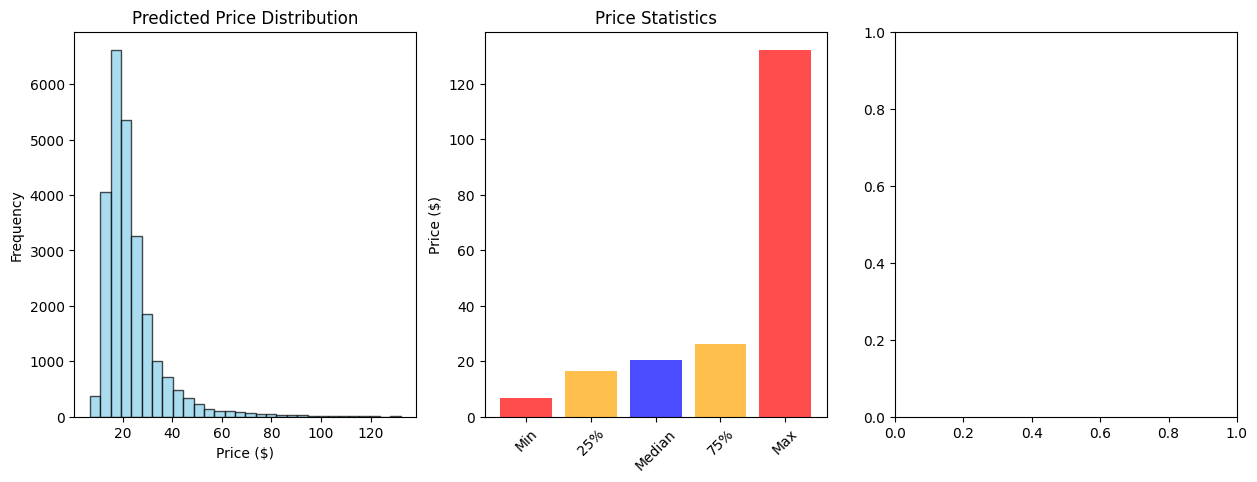

In [5]:
# OPTIMIZED PIPELINE EXECUTION

def run_optimized_pipeline(train_file='../data/train.csv', test_file='../data/test.csv', method='optimized'):
    """
    Optimized pipeline targeting 20-30% SMAPE
    """
    try:
        print(f"🎯 OPTIMIZED PIPELINE - Targeting Low SMAPE")
        print("=" * 50)
        
        # 1. Load data
        print("1. Loading data...")
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
        
        print(f"   Training: {train_df.shape}, Test: {test_df.shape}")
        
        # 2. Choose model based on requirements
        if method == 'optimized':
            predictor = LowSMAPEPredictor()
            results = predictor.train_optimized(train_df, quick_tune=True)
        elif method == 'ensemble':
            predictor = EnsembleLowSMAPEPredictor()
            results = predictor.train_ensemble(train_df)
        else:
            raise ValueError("Choose 'optimized' or 'ensemble'")
        
        # 3. Make predictions
        print("3. Making predictions...")
        predictions = predictor.predict(test_df)
        
        # 4. Save results
        output_file = f'../Model/optimized_predictions_{method}.csv'
        predictions[['sample_id', 'predicted_price']].to_csv(output_file, index=False)
        
        print("4. Results summary:")
        print(f"   Predictions saved: {output_file}")
        print(f"   Products predicted: {len(predictions)}")
        print(f"   Price range: ${predictions['predicted_price'].min():.2f} - ${predictions['predicted_price'].max():.2f}")
        
        if 'smape' in results:
            print(f"   Validation SMAPE: {results['smape']:.2f}%")
            if results['smape'] <= 30:
                print("   🎉 EXCELLENT! SMAPE is in target range (≤30%)")
            elif results['smape'] <= 40:
                print("   ✅ GOOD! SMAPE is acceptable (≤40%)")
            else:
                print("   ⚠️  SMAPE needs improvement")
        
        # Enhanced visualization
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(predictions['predicted_price'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Predicted Price Distribution')
        plt.xlabel('Price ($)')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 3, 2)
        price_stats = predictions['predicted_price'].describe()
        metrics = ['Min', '25%', 'Median', '75%', 'Max']
        values = [price_stats['min'], price_stats['25%'], price_stats['50%'], price_stats['75%'], price_stats['max']]
        colors = ['red', 'orange', 'blue', 'orange', 'red']
        plt.bar(metrics, values, color=colors, alpha=0.7)
        plt.title('Price Statistics')
        plt.ylabel('Price ($)')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 3)
        if hasattr(predictor.model, 'feature_importances_'):
            features = predictor.feature_columns
            importances = predictor.model.feature_importances_
            sorted_idx = np.argsort(importances)[-8:]  # Top 8
            plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
            plt.title('Top 8 Features')
        else:
            plt.text(0.5, 0.5, 'Feature Importance\nNot Available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes)
            plt.title('Feature Importance')
        
        plt.tight_layout()
        plt.show()
        
        return predictor, predictions, results
        
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# RUN THE OPTIMIZED PIPELINE
print("🎯 Starting optimized training for low SMAPE...")
##optimized_predictor, optimized_predictions, optimized_results = run_optimized_pipeline('../data/train.csv', '../data/test.csv', method='optimized')

# For even better accuracy (but slower), use ensemble:
ensemble_predictor, ensemble_predictions, ensemble_results = run_optimized_pipeline('../data/train.csv', '../data/test.csv', method='ensemble')